作者： 姚舜禹  
https://doi.org/10.20944/preprints202510.1834.v1

SimProfile: A Monte Carlo Surface Profile Simulator with Data-Driven Parameter Calibration

In [ ]:
import pyvista as pv
import numpy as np
import os
import postProcess
import particleGenerator
from numba import jit
import semicraft
import surface_normal

In [ ]:
# cell size [x][y][z][FILMSIZE]

FILMSIZE = 2
zoom_in = 2.5
density = 50

In [ ]:
# hole

@jit(nopython=True)
def inputFilm_benchmark_hole():

    top = 200
    film = np.ones((100, 100, top, 2), dtype=np.int32)*density
    # density = 20
    # sphere = np.ones((cellx, HardMasK.shape[1], HardMasK.shape[0], FILMSIZE), dtype=bool)
    # sphere = np.ones((cellx, HardMasK.shape[1], HardMasK.shape[0], FILMSIZE), dtype=np.uint8)
    center = 50
    shift = 0

    depth = 50

    radius = 50

    print(radius)

    for j in range(top):

        for x in range(film.shape[0]):
            for y in range(film.shape[1]):
                if np.abs(x-center)*np.abs(x-center) + np.abs(y-center-shift)*np.abs(y-center-shift) < radius*radius/4:
                    film[x, y, -j, :] = 0
        # else:
        #     print('j ', j)
        #     film[:, :, -j, :] = 0


            # film[sphere, :] = density
    film[:, :, :10, 0] = density
    film[:, :, (depth + 10):, :] = 0


    return film

In [ ]:
color_names = ['dimgray', 'cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'Cu', 'SiOxFy', 'mask']
geom = pv.Box()
p = pv.Plotter()


film = inputFilm_benchmark_hole()
# film = inputFilm_pegasus()
# film = inputFilm("./sf_250410_1_1.jpg")
# film = inputFilm("./cu_depo_0930.jpg")
layer =postProcess.layerLoop(film[:,:,:,:])
for ci in range(film.shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci])

p.enable_eye_dome_lighting()
p.add_legend(size=(0.2, 0.2))
p.show()

In [ ]:
# trench

depth = 50
density = 50
film = np.zeros((200, 200, 100, 2), dtype=np.int32)
film[:, :, :10, 0] = density
film[:, :50, :10+depth, 0] = density
film[:, 150:, :10+depth, 0] = density

In [ ]:
color_names = ['dimgray', 'cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'Cu', 'SiOxFy', 'mask']
geom = pv.Box()
p = pv.Plotter()


# film = inputFilm_benchmark_hole()
# film = inputFilm_pegasus()
# film = inputFilm("./sf_250410_1_1.jpg")
# film = inputFilm("./cu_depo_0930.jpg")
layer =postProcess.layerLoop(film[:,:,:,:])
for ci in range(film.shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci])

p.enable_eye_dome_lighting()
p.add_legend(size=(0.2, 0.2))
p.show()

In [ ]:
# surface normal calculation

sumFilm = np.sum(film, axis=-1)
mirrorGap = 3
cellSizeX, cellSizeY, cellSizeZ = sumFilm.shape
film_label_index_normal, curvatures_field = surface_normal.build_film_label_index_normal(sumFilm, mirrorGap)

curvatures_field[:3, :, :] = curvatures_field[3:6, :, :]
curvatures_field[-3:, :, :] = curvatures_field[-6:-3, :, :]

cellid = np.ascontiguousarray(film_label_index_normal[:,:,:,0].copy(), dtype=np.int32)
cellnormal = np.ascontiguousarray(film_label_index_normal[:,:,:,-3:].copy(), dtype=np.double)
cellfilm = np.ascontiguousarray(film.copy(), dtype=np.int32)
cellindex = np.ascontiguousarray(film_label_index_normal[:,:,:,1:4].copy(), dtype=np.int32)

In [ ]:
# surface normal visualization

color_names = ['dimgray', 'blue', 'red', 'green','cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'SiCl1', 'SiCl2', 'SiCl3', 'mask']

geom = pv.Box()
p = pv.Plotter()

layer = postProcess.layerLoop(film)

for ci in range(film.shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci],opacity=0.7)

plane = postProcess.transfer_to_plane(cellid, cellnormal)

point_cloud = pv.PolyData(plane[:, 3:6])
vectors = plane[:, :3]

point_cloud['vectors'] = vectors
arrows = point_cloud.glyph(
    orient='vectors',
    scale=10000,
    factor=3,
)

p.add_mesh(point_cloud, color='cyan', point_size=5.0, render_points_as_spheres=True)
p.add_mesh(arrows, color='lightblue', opacity= 0.1)

p.enable_eye_dome_lighting()
p.add_legend()
p.show()

In [ ]:
# set reaction table

react_table_equation =   np.array([[[ 1,  0], # Si-Si
                                    [ 1,  0]], # Si-Al

                                    [[ 0,  1], # Si-Al
                                    [ 0,  1]], # Al-Al

                                    [[-1,  0],
                                    [ 0, -1]]], dtype=np.int32) # AL-Argon

react_table_equation = np.ascontiguousarray(react_table_equation, dtype=np.int32)

react_type_table =np.array([[3, 3], # 3 for redeposition
                            [3, 3],
                            [2, 2]], dtype=np.int32) #Al-ion # 2 for physics sputter    

react_prob_chemical = np.array([[0.9, 0.9],
                                [0.9, 0.9],
                                [0.5, 0.5]])

react_prob_chemical = np.ascontiguousarray(react_prob_chemical, dtype=np.double)

reflect_probability = np.ones((3, 2), dtype=np.double) 
reflect_coefficient = np.ones((3, 2), dtype=np.double) 


react_yield_p0 = np.array([0.00, 0.00])

#surface binding energy
film_eth = np.array([15, 15], dtype=np.double)

# deprecated Reflection probability curve
rn_coeffcients = np.array([[0.9423, 0.9434, 2.742, 3.026], # c1 c2 c3 c4
                            [0.9620, 0.9608, 2.542, 3.720],
                            [0.9458, 0.9445, 2.551, 3.735],
                            [1.046, 1.046, 2.686, 4.301]])

sputter_yield_coefficient = np.array([[0.9163, 0.2862, 1.1638],
                                        [0.5536, 0.2195, 0.4457]])

E_decrease = np.zeros((3,2)) # depo Al-Ar

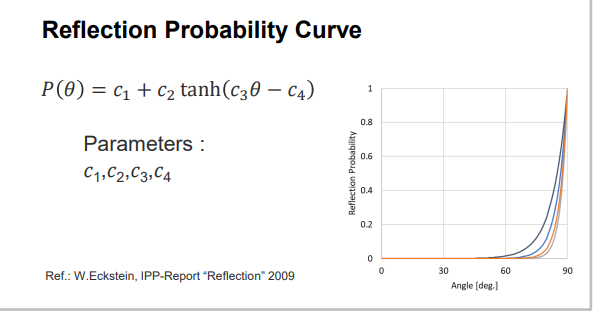

In [ ]:
chemical_angle_v1 = (89/180)*np.pi
chemical_angle_v2 = (90/180)*np.pi

In [ ]:
# set initial particle positions


def posGenerator_top_nolength(IN, cellSizeX, cellSizeY, cellSizeZ, emptyZ):
    # emptyZ = 10
    position_matrix = np.array([np.random.rand(IN)*cellSizeX, \
                                np.random.rand(IN)*cellSizeY, \
                                np.random.uniform(0, emptyZ, IN) + cellSizeZ - emptyZ], dtype=np.double).T
    return position_matrix


In [ ]:
folder_path = "./example_depo/"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"文件夹已创建：{folder_path}")
else:
    print(f"文件夹已存在：{folder_path}")



N = int(1e7)

# o2_ratio = 0.5
# particle_list = [[N, 0, 'cosn', 50, cosn]] # [int(N*Ar_ratio), 2, 'cosn', 50, cosn]
# particle_list = [[int(N*(1-Ar_ratio)), 0, 'maxwell', 50, 300, 9], [int(N*Ar_ratio), 1, 'guass', 50, sigma_ion]]
# particle_list = [[int(N*(1-Ar_ratio)), 1, 'maxwell', 50, 300, 9], [int(N*Ar_ratio*depo_ratio), 2, 'guass', 50, sigma_ion], [int(N*Ar_ratio*(1-depo_ratio)), 1, 'guass', 50, sigma_ion]]
# particle_list = [[int(N*(1-Ar_ratio)*(1-o2_ratio)), 0, 'maxwell', 50, 300, 9], [int(N*(1-Ar_ratio)*(o2_ratio)), 1, 'maxwell', 50, 300, 16], [int(N*Ar_ratio), 2, 'guass', 50, sigma_ion]]
# particle_list = [[int(N), 0, 'maxwell', 50, 300, 9]]
particle_list = [[int(N), 1, 'maxwell_energy', 50, 300, 9]]

vel_matrix = particleGenerator.vel_generator(particle_list)
vel = vel_matrix[:, :3].copy()

# pegasus_vel_input
# vel = pegasus_vel_input()


vel = np.ascontiguousarray(vel, dtype=np.double)
id = np.ones(vel.shape[0]).astype(np.int32)
E = np.ones(vel.shape[0])*50
# **创建临时 pickle 文件**

# max_particles = 128000
max_particles = 2048000
pos = posGenerator_top_nolength(vel.shape[0], cellSizeX, cellSizeY, cellSizeZ, 3)
pos = np.ascontiguousarray(pos, dtype=np.double)

seed = 125
simulation = semicraft.Simulation(seed, cellSizeX, cellSizeY, cellSizeZ, FILMSIZE, density, max_particles)

# simulation.set_all_parameters(react_table_equation, react_type_table, 
#                             react_prob_chemical, react_yield_p0, 
#                             film_eth, rn_coeffcients, E_decrease)

simulation.set_all_parameters(react_table_equation, react_type_table, reflect_probability, reflect_coefficient,
                            react_prob_chemical, react_yield_p0, 
                            film_eth, rn_coeffcients, E_decrease)

simulation.input_sputter_yield_coefficient(sputter_yield_coefficient)
simulation.inputCell(cellid, curvatures_field, cellindex, cellnormal, cellfilm)
simulation.inputParticle(pos, vel, E, id)

depo_or_etch = 1 # depo for 1, etch for -1 
ArgonID = 2
diffusion = False
diffusion_coeffient = 3.0
diffusion_distant = 1
redepo = False
# **运行 Simulation**
depth = 50
thick = 25
stopPointY = 10
stopPointZ = 10 + depth + thick
simulation_step_rm = int(2e8)
relaxTime = 100
needrecompute = simulation.runSimulation(simulation_step_rm, ArgonID, depo_or_etch, redepo, diffusion, diffusion_coeffient, diffusion_distant, stopPointY, stopPointZ, chemical_angle_v1, chemical_angle_v2, relaxTime)
# needrecompute = simulation.runSimulation(simulation_step_rm, ArgonID, reflect_coefficient, depo_or_etch, redepo, diffusion, diffusion_coeffient, diffusion_distant, stopPointY, stopPointZ, chemical_angle_v1, chemical_angle_v2)
# needrecompute = simulation.runSimulation(data["simulation_step_rm"], 2, data["reflect_coefficient"], data["E_decrease"], data["stopPointY"], data["stopPointZ"], data["chemical_angle_v1"], data["chemical_angle_v2"])
print(f"needrecompute: {needrecompute}")

iter = 1
if needrecompute == 0:
    print("Simulation finished")
    typeID_array, film_array, potential_array = simulation.cell_data_to_numpy()
    normal_array = simulation.normal_to_numpy()
    np.save(f"{folder_path}/film_{iter}.npy", film_array)
    # np.save(f"./calibration_0804_benchmark/typeID_{i}_{iter}.npy", typeID_array)
    # np.save(f"./calibration_0804_benchmark/potential_{i}_{iter}.npy", potential_array)
    # np.save(f"./calibration_0804_benchmark/normal_{i}_{iter}.npy", normal_array)
    print(f"save finished_{iter}_")

In [ ]:
color_names = ['dimgray', 'cyan', 'black', 'white','yellow', 'brown', 'magenta', 'orange', 'purple', 'pink', 'gray']
labels = ['Si', 'Cu', 'SiOxFy', 'mask']
geom = pv.Box()
p = pv.Plotter()

n = 35
film = np.load(f'./{folder_path}/film_{iter}.npy')
# film = inputFilm_pegasus()
# film = inputFilm("./sf_250410_1_1.jpg")
# film = inputFilm("./cu_depo_0930.jpg")
layer =postProcess.layerLoop(film[:,:,:,:])
for ci in range(film.shape[3]):
    layerCube = np.argwhere(layer == ci+1)
    if layerCube.size != 0:
        layermesh = pv.PolyData(layerCube)
        layermesh["radius"] = np.ones(layerCube.shape[0])*0.5
        layerglyphed = layermesh.glyph(scale="radius", geom=geom, orient=False) # progress_bar=True)
        p.add_mesh(layerglyphed, color=color_names[ci], label=labels[ci])

p.enable_eye_dome_lighting()
p.add_legend(size=(0.2, 0.2))
p.show()